In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.svm import LinearSVC
from copy import copy

import warnings

warnings.filterwarnings("ignore")

In [36]:
sns.set_theme()
sns.set(context="paper", palette="Set2", font_scale=2)

In [37]:
# sns.set(font="Times New Roman")

# Helpful functions

In [38]:
def get_only_four(lipids):
    """Obtain the regions for which exactly four observations for distinct brains are available."""
    brains_per_region = lipids.groupby("region")["human"].apply(
        lambda x: str(sorted(list(x)))
    )
    brains_set = str(sorted(list(set(lipids.human.unique()))))
    only_four = set(brains_per_region[brains_per_region == brains_set].index)
    return only_four


def normalize_slow(dataset):
    """Subtract mean over regions for every molecule in each brain."""
    new_dataset = []
    for brain in sorted(dataset.human.unique()):
        existing_values = dataset[dataset["human"] == brain].iloc[:, 2:]
        mean_per_brain = existing_values.mean()
        new_dataset.append(existing_values.values - mean_per_brain.values)

    new_dataset = pd.DataFrame(np.concatenate(new_dataset))
    new_dataset.insert(loc=0, column="human", value=dataset.human.values)
    new_dataset.insert(loc=1, column="region", value=dataset.region.values)
    new_dataset.columns = dataset.columns
    return new_dataset


def normalize(dataset):
    means = dataset.drop(columns=["region"]).groupby("human").mean().reset_index()
    mean_repeated = means.iloc[
        means.index.repeat(dataset.region.nunique())
    ].reset_index(drop=True)
    dataset.iloc[:, 2:] = dataset.iloc[:, 2:] - mean_repeated.iloc[:, 1:]
    return dataset


def prepare_for_dim_reduction(dataset):
    """Reshape the dataset in such a way that all observation for each brain become a single vector."""
    new_dataset = []
    for brain in sorted(dataset.human.unique()):
        existing_values = (
            dataset[dataset["human"] == brain].iloc[:, 2:].values.reshape(1, -1)
        )
        new_dataset.append(existing_values)
    new_dataset = np.concatenate(new_dataset)
    return new_dataset


def check_normalization(dataset):
    for brain in dataset.human.unique():
        if abs(dataset[dataset.human == brain].mean().mean()) > 1e-10:
            print("Unnormalized")
            return
    print("Normalized")
    return

In [39]:
# %load_ext autoreload
# %autoreload 2

import sys

sys.path.append("..")
from utils import get_tr_data

# read the data

In [40]:
use_genes = False

In [41]:
onebatch = pd.read_csv("../data/OneBatch3_FINAL2.csv").sort_values(
    by=["Donor", "Region"]
)

h_molecules = pd.read_csv(
    "../data/ours_maria_version/rtmz_H_pos_std_weight_norm_TL_COMBINED.csv", index_col=0
)
sz_molecules = pd.read_csv(
    "../data/ours_maria_version/rtmz_SZ_pos_std_weight_norm_TL_COMBINED.csv",
    index_col=0,
)

h_molecules.index = h_molecules.index.str.split(".").str[0]

meta = pd.read_csv("../data/ours_maria_version/meta_pos_COMBINED.csv")
meta = meta[["Sample", "Brain_abbr", "Region_detailed"]].set_index("Sample")

sz_molecules = meta.join(sz_molecules, how="inner")
# sz_molecules["region_id"] = sz_molecules.Region_detailed.str.split(" ").str[0].astype(int)

h_molecules = meta.join(h_molecules, how="inner")
# h_molecules["region_id"] = h_molecules.Region_detailed.str.split(" ").str[0].astype(int)

meta_lipids = pd.read_csv("../data/ours_maria_version/TL_combined.csv")
lipid_species_colon_replaced = (
    meta_lipids["Lipid.species"].str.replace(":", " ", regex=False).tolist()
)
lipids_columns = ["Brain_abbr", "Region_detailed"] + lipid_species_colon_replaced
h_molecules.columns = lipids_columns
sz_molecules.columns = lipids_columns

h_molecules = (
    h_molecules.sort_values(by=["Brain_abbr", "Region_detailed"])
    .rename(columns={"Brain_abbr": "human", "Region_detailed": "region"})
    .reset_index(drop=True)
)
sz_molecules = sz_molecules.sort_values(by=["Brain_abbr", "Region_detailed"]).rename(
    columns={"Brain_abbr": "human", "Region_detailed": "region"}
)

if use_genes:
    h_molecules = get_tr_data(True).reset_index().drop(columns=["batch"])
    sz_molecules = get_tr_data(False).reset_index().drop(columns=["batch"])
    common_columns = list(h_molecules.columns[:2]) + sorted(
        list(set(h_molecules.columns[2:]) & set(sz_molecules.columns[2:]))
    )
    h_molecules = h_molecules[common_columns]
    sz_molecules = sz_molecules[common_columns]

In [42]:
h_molecules.groupby("region")["human"].apply(len)

region
1  Cerebellar Grey Matter                   4
10 2ary/3ary Visual Posterior (BA18/19p)    4
11 2ary Auditory Posterior (BA21p)          5
12 Premotor Posterior (BA6p)                2
13 Premotor Precentral (BA6prc)             2
                                           ..
73 Corpus Callosum Anterior                 4
74 Corpus Callosum Posterior                4
75 Cerebellar White Matter                  4
8  Cingulate Posterior (BA23a)              4
9  2ary Somatosensory Cortex                5
Name: human, Length: 75, dtype: int64

In [43]:
vc_h = h_molecules.region.value_counts()
vc_sz = sz_molecules.region.value_counts()

In [44]:
vc = pd.concat([vc_h, vc_sz], axis=1).reset_index()
vc.columns = ["Region", "HC samples", "SZ samples"]
vc.Region = vc.Region.apply(lambda x: " ".join(x.split()[1:]))

In [45]:
# print(", ".join(vc[(vc["HC samples"] == 4) & (vc["SZ samples"] == 4)].Region.tolist()))

In [46]:
# print(vc[(vc["HC samples"] != 4) | (vc["SZ samples"] != 4)].reset_index(drop=True).to_latex(index=False))
# print(vc.reset_index(drop=True).to_latex(index=False))

## Investigate

In [47]:
regions_75_lipids = meta_lipids["Lipid.species"].str.replace(":", " ").unique().tolist()
onebatch_molecules = onebatch.columns[9:].str.replace(".", " ", regex=False).tolist()
common_molecules = list(set(regions_75_lipids) & set(onebatch_molecules))
common_molecules = np.array(common_molecules)
print("Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:")
print(len(regions_75_lipids), len(onebatch_molecules), len(common_molecules))
duplicates = h_molecules.columns.value_counts()[
    h_molecules.columns.value_counts() != 1
].index
print("\nCommon lipids after removing duplicates:")
common_molecules = list(set(common_molecules) - set(duplicates))
print(len(common_molecules))

h_only_four = get_only_four(h_molecules)
sz_only_four = get_only_four(sz_molecules)
regions_only_four = list(h_only_four & sz_only_four)
print("\nNum of regions for which there are 4 SZ and 4 HC observations")
print(len(regions_only_four))

Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:
347 445 58

Common lipids after removing duplicates:
53

Num of regions for which there are 4 SZ and 4 HC observations
50


In [48]:
onebatch = onebatch.rename(columns={"Donor": "human"})
onebatch.columns = onebatch.columns.str.replace(".", " ", regex=False)
onebatch_only_common = copy(onebatch[onebatch.columns[:9].tolist() + common_molecules])
onebatch_only_common.iloc[:, 9:] *= np.log10(2)
onebatch_only_common.head()

,Unnamed: 0,Sample,SZ,Type,Region,human,Order,Mass,MassCoef,LPC 20 3,...,LPC 18 0,LPE 24 4,FA 24 1,FA 20 5,PC 35 3,FA 18 2,PC 37 1,LPE 20 4,PC 37 2,LPE 18 0
3,V22,HC10M_f_36_CCp_x2_NEG_068,HC,Sample,BA22,HC10M,68,18.6,-0.048999,5.411370,...,6.609476,4.629900,4.399409,5.625274,6.017982,6.255731,5.659006,6.938006,5.860528,5.858920
1,V20,HC10M_f_36_BA9_x2_NEG_041,HC,Sample,BA9,HC10M,41,16.4,-0.230605,5.323759,...,6.479667,4.413117,4.125364,5.341771,6.187377,5.999318,5.420468,6.796520,5.585510,5.934678
0,V19,HC10M_f_36_BA22p_x2_NEG_093,HC,Sample,CCp,HC10M,93,24.9,0.371845,4.924550,...,6.390225,5.094628,5.425013,5.391641,5.466151,5.961067,6.222331,6.243931,7.021830,4.746306
2,V21,HC10M_f_36_CCa_x2_NEG_092,HC,Sample,Cca,HC10M,92,21.1,0.132942,4.763908,...,6.389490,5.089776,5.494129,5.789852,4.460293,6.226076,5.952537,6.407568,6.774656,4.831972
4,V23,HC16M_f_54_BA22p_x2_NEG_006,HC,Sample,BA22,HC16M,6,14.6,-0.398333,4.792293,...,6.449459,5.245931,4.812282,5.124707,5.984818,5.701896,5.460669,6.733909,6.001885,5.595182


OneBatch is log2 data. 75_regions is log10 data. Therefore, we multiply Onebatch by $\log_{10}(2)$, because $\log_{10}(x) = \log_{10}(2) \times \log_2(x)$

## Normalize (make mean value for each molecule in each brain zero)

In [49]:
dataset = onebatch
new_dataset = []
for brain in dataset.human.unique():
    existing_values = dataset[dataset["human"] == brain].iloc[:, 9:]
    mean_per_brain = existing_values.mean()
    new_dataset.append((existing_values.values - mean_per_brain.values))

new_dataset = pd.DataFrame(np.concatenate(new_dataset))

new_dataset = pd.concat([onebatch.iloc[:, :9], new_dataset], axis=1)
new_dataset.columns = onebatch.columns
onebatch = new_dataset

In [50]:
sz_molecules = sz_molecules[sz_molecules.region.isin(regions_only_four)].reset_index(
    drop=True
)
sz_molecules = normalize(sz_molecules)

In [51]:
h_molecules = h_molecules[h_molecules.region.isin(regions_only_four)].reset_index(
    drop=True
)
h_molecules = normalize(h_molecules)

In [52]:
# Check normalization
# check_normalization(sz_molecules)
# check_normalization(onebatch)
# check_normalization(h_molecules)

In [53]:
all_observations_combined_75 = np.concatenate(
    [h_molecules.iloc[:, 2:].values, sz_molecules.iloc[:, 2:].values]
).reshape(
    -1,
)

In [54]:
all_observations_combined_75.shape

(151600,)

In [55]:
all_observations_combined_75

array([-0.50398727, -1.18887342, -0.47377342, ...,  0.52677074,
        0.58360673,  0.92461069])

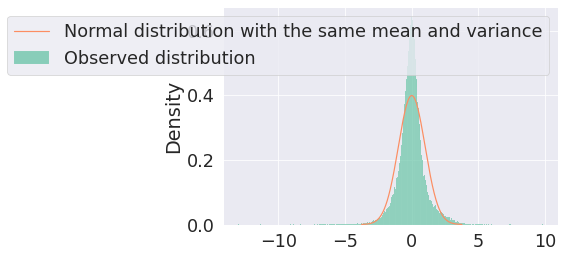

In [56]:
left_point = norm.ppf(
    0.0001,
    loc=all_observations_combined_75.mean(),
    scale=all_observations_combined_75.std(),
)
right_point = (
    norm.ppf(
        0.9999,
        loc=all_observations_combined_75.mean(),
        scale=all_observations_combined_75.std(),
    ),
)
x = np.linspace(left_point, right_point, 1000)
plt.plot(
    x, norm.pdf(x), c="C1", label="Normal distribution with the same mean and variance"
)
sns.histplot(
    all_observations_combined_75, stat="density", label="Observed distribution"
)
plt.legend()
plt.show()

## Data visualization

### 75_regions (normalized), brain as object

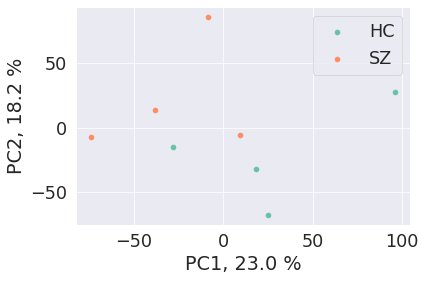

In [57]:
h_molecules_dim_reduction = prepare_for_dim_reduction(
    h_molecules[h_molecules.region.isin(regions_only_four)]
)
sz_molecules_dim_reduction = prepare_for_dim_reduction(
    sz_molecules[sz_molecules.region.isin(regions_only_four)]
)

dim_reduction = PCA(n_components=2)

lipids_dim_reduction = dim_reduction.fit_transform(
    np.concatenate([h_molecules_dim_reduction, sz_molecules_dim_reduction])
)

plt.scatter(lipids_dim_reduction[:4, 0], lipids_dim_reduction[:4, 1], label="HC")
plt.scatter(lipids_dim_reduction[4:, 0], lipids_dim_reduction[4:, 1], label="SZ")
plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"75 regions dataset (50 taken)")

plt.legend()
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_real.png"
)
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_real.pdf",
    bbox_inches="tight",
)

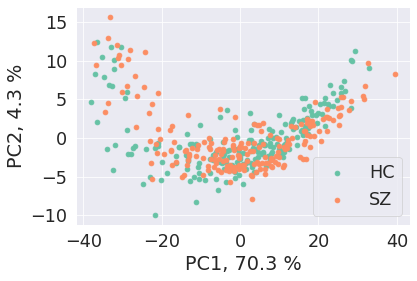

In [58]:
h_molecules_dim_reduction = h_molecules[
    h_molecules.region.isin(regions_only_four)
].iloc[:, 2:]
sz_molecules_dim_reduction = sz_molecules[
    sz_molecules.region.isin(regions_only_four)
].iloc[:, 2:]

dim_reduction = PCA(n_components=2)

lipids_dim_reduction = dim_reduction.fit_transform(
    np.concatenate([h_molecules_dim_reduction, sz_molecules_dim_reduction])
)

border = lipids_dim_reduction.shape[0] // 2

plt.scatter(
    lipids_dim_reduction[:border, 0], lipids_dim_reduction[:border, 1], label="HC"
)
plt.scatter(
    lipids_dim_reduction[border:, 0], lipids_dim_reduction[border:, 1], label="SZ"
)
plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"75 regions dataset (50 taken)")

plt.legend()
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_real.png"
)
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_real.pdf",
    bbox_inches="tight",
)

### One batch (normalized), brain as object

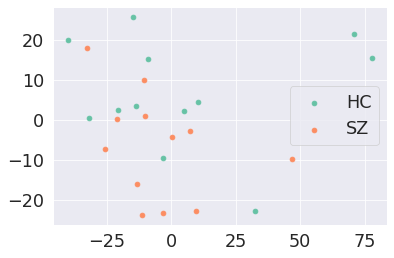

In [59]:
new_onebatch = []
for brain in onebatch.human.unique():
    existing_values = (
        onebatch[onebatch["human"] == brain].iloc[:, 9:].values.reshape(1, -1)
    )
    new_onebatch.append(existing_values)
new_onebatch = np.concatenate(new_onebatch)

dim_reduction = PCA(n_components=2)

dim_reduction_fitted = dim_reduction.fit_transform(new_onebatch)

plt.scatter(dim_reduction_fitted[:12, 0], dim_reduction_fitted[:12, 1], label="HC")
plt.scatter(dim_reduction_fitted[12:, 0], dim_reduction_fitted[12:, 1], label="SZ")
plt.legend()
plt.show()

## Example lipid profile

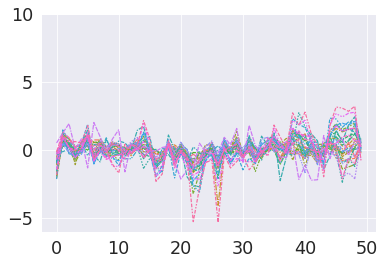

In [60]:
if not use_genes:
    sns.lineplot(
        h_molecules[h_molecules["human"] == "HA"].loc[
            :, h_molecules.columns.str.contains("FA")
        ],
        legend=None,
    )
    plt.ylim(-6, 10)
    #     plt.title("All Fatty Acid profiles in one of the brains")
    #     plt.legend(False)
    plt.savefig("../data/pics/example_profiles.pdf", bbox_inches="tight")

- BA9: 35 Dorsolateral Prefrontal Medial (BA9m), 34 Dorsolateral Prefrontal (BA9)
- BA22: 26 2ary Auditory, language (BA22a), 28 2ary Auditory, Wernicke (BA22p)

In [61]:
# region_translate = {
#     "CCp": '74 Corpus Callosum Posterior',
#     "BA9": "34 Dorsolateral Prefrontal (BA9)",
#     "Cca": '73 Corpus Callosum Anterior',
#     "BA22": "28 2ary Auditory, Wernicke (BA22p)",
# }

region_translate = {
    "74 Corpus Callosum Posterior": "CCp",
    "34 Dorsolateral Prefrontal (BA9)": "BA9",
    "73 Corpus Callosum Anterior": "Cca",
    "28 2ary Auditory, Wernicke (BA22p)": "BA22",
}

# Generate fake dataset

## Prepare the labels

In [62]:
N_SAMPLES = 100 if use_genes else 1000
# for each class SZ and SZ
# 100 for lipids is too few
# 1000 for genes makes the kernel die
# 10000 for lipids makes the kernel die


brains_labels_hc = [f"HC{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels_sz = [f"SZ{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels = np.array(brains_labels_hc + brains_labels_sz)

regions_labels = np.concatenate(
    [np.array([region] * N_SAMPLES) for region in regions_only_four]
)
regions_labels = np.concatenate([regions_labels, regions_labels])

## Sampling

In [63]:
if use_genes:
    common_molecules = np.array(h_molecules.columns[2:].tolist())
else:
    vc = pd.Series(h_molecules.columns[2:]).value_counts()
    common_molecules = vc[vc == 1].index.tolist()

In [83]:
fake_dataset = []
fake_dataset_75 = []
std_comparison = []

hc_column = []
region_nm_column = []

for human_type in ["HC", "SZ"]:
    for region_nm in regions_only_four:

        # First, we generate the data based on 75_regions (taking 50 of them)
        # In this loop we generate N_SAMPLES individuals for each region_nm
        if human_type == "HC":
            regions_75_lipids = h_molecules[h_molecules["region"] == region_nm][
                common_molecules
            ]
        else:
            regions_75_lipids = sz_molecules[sz_molecules["region"] == region_nm][
                common_molecules
            ]

        generated_75 = np.random.normal(
            loc=regions_75_lipids.mean(),
            scale=regions_75_lipids.std(),
            size=(N_SAMPLES, len(common_molecules)),
        )
        fake_dataset_75.append(generated_75)

        # Second, we generate the data based on OneBatch
        if not use_genes:
            if region_nm in region_translate:
                to_plot = onebatch_only_common[
                    (onebatch_only_common.SZ == human_type)
                    & (onebatch_only_common.Region == region_translate[region_nm])
                ]
                onebatch_molecules = to_plot[common_molecules]

                # We save the mean fold-difference between variances
                std_comparison.append(
                    [
                        human_type,
                        region_nm,
                        (regions_75_lipids.var() / onebatch_molecules.var()).mean(),
                    ]
                )

                generated = np.random.normal(
                    loc=onebatch_molecules.mean(),
                    scale=onebatch_molecules.std(),
                    size=(N_SAMPLES, len(common_molecules)),
                )
                fake_dataset.append(generated)

KeyError: "['PE_P 41 7', 'PE_O 42 7', 'PC 29 0', 'PE_P 39 2', 'PE_P 39 4', 'LPE 22 3', 'PE_P 40 2', 'PC_P 38 6', 'PC_P 38 5', 'PE_P 42 4', 'PC_P 38 4', 'PC_O 36 2', 'PE_P 40 7', 'PC_P 34 1', 'PC_P 30 0', 'PC_P 34 2', 'PC_P 38 2', 'PE_P 40 8', 'PC_O 36 4', 'PE_P 41 5', 'PC_P 36 2', 'PC_P 36 1', 'PC_P 32 1', 'DG 34 1', 'PE_P 38 1', 'PE 42 6', 'PE 40 6', 'PE 40 4', 'PE 40 3', 'PE 39 4', 'PE 38 7', 'PE 38 2', 'PE 38 1', 'PE 37 4', 'PE 36 6', 'PE 36 5', 'PE 35 2', 'PE 35 1', 'PE 34 3', 'PE 34 2', 'PE 32 1', 'PE 42 5', 'PE 42 10', 'PE_P 37 4', 'PE 42 7', 'PE_P 37 3', 'PC 31 1', 'PE_P 37 2', 'PE_P 37 1', 'PE_P 36 5', 'PE_P 36 3', 'PE_P 36 2', 'PE_P 35 2', 'PE_P 35 1', 'PE_P 34 2', 'PE_P 33 1', 'PE_P 32 1', 'PG 42 9', 'PG 40 8', 'PG 40 7', 'PG 38 6', 'PG 34 2', 'PC 31 0', 'PC 35 4', 'PC 33 2', 'SulfoHexCer t43 2', 'FA 17 1', 'FA 14 0', 'SulfoHexCer t44 2', 'SulfoHexCer d44 2', 'FA 19 0', 'SulfoHexCer t42 1', 'SulfoHexCer d43 1', 'SulfoHexCer t42 2', 'SulfoHexCer d43 2', 'SulfoHexCer t41 1', 'SulfoHexCer d42 1', 'SulfoHexCer d42 2', 'SulfoHexCer t40 1', 'FA 18 3', 'FA 19 1', 'SulfoHexCer d40 1', 'FA 24 6', 'FA 22 7', 'FA 21 3', 'FA 20 2', 'SulfoHexCer d41 1', 'PI 40 6', 'PC 34 4', 'PC 40 1', 'PE_O 38 4', 'PE_P 34 0', 'PE 40 8', 'PE 39 6', 'PE 38 5', 'PC 40 5', 'PC 40 2', 'PC_O 32 1', 'PC 36 5', 'PC 36 4', 'PC 35 0', 'PE_O 40 4', 'PC_P 37 1', 'PI 38 6', 'PC_O 38 5', 'PI 38 5', 'PI 38 4', 'PI 36 4', 'PC_O 40 7', 'PC_P 40 5', 'PC_P 40 4', 'PC_O 40 4', 'PC_O 38 6', 'PC_O 38 1', 'PC_P 38 1', 'PC_O 36 1', 'PC_O 35 2', 'PC_O 34 2', 'PC_O 34 1', 'PC_O 34 0', 'PC_O 32 0', 'PC_O 30 0', 'PC_P 40 2', 'PC 40 8', 'Cer m44 2', 'Cer m43 2', 'Cer m42 2', 'Cer m41 2', 'Cer m39 1', 'Cer d38 2', 'Cer t36 0', 'Cer m38 1', 'Cer d36 0', 'Cer m36 0', 'Cer d35 1', 'Cer m36 1', 'HexCer t43 2', 'HexCer d44 2', 'HexCer d43 2', 'HexCer d42 1', 'HexCer d41 1', 'HexCer d36 1', 'DG 37 4', 'DG 38 5', 'DG 38 1', 'PS 40 5', 'CE 22 6', 'CE 22 4', 'CE 20 4', 'CE 20 3', 'CE 18 2', 'CE 18 1', 'HexCer t36 2', 'SM d38 0', 'SM d32 0', 'HexCer d43 1', 'HexCer t41 2', 'HexCer t40 2', 'HexCer d40 1', 'HexCer d38 1', 'HexCer d36 2', 'Cer d41 2', 'PC 42 10', 'Cer d40 1', 'DG 42 4', 'HexCer d42 2', 'Cer d43 2', 'Cer d42 2', 'Cer m44 1', 'SM d36 1', 'SM d36 2', 'SM d35 1', 'SM d34 2', 'DG 40 2', 'DG 40 4', 'DG 38 2', 'DG 38 4', 'DG 36 1', 'DG 36 2', 'DG 36 3', 'DG 36 4', 'SM d32 1', 'SM d33 1', 'SM d34 1', 'SM d41 1', 'Cer m41 1', 'Cer m40 1', 'Cer d36 2', 'SM d44 2', 'SM d43 2', 'SM d42 1', 'SM d42 2', 'SM d41 2', 'SM d34 0', 'SM d40 1', 'SM d40 2', 'SM d38 1', 'SM d37 1', 'SM d37 2', 'SM d36 0', 'SM d35 2', 'PS 40 6', 'TG 50 3', 'TG 52 4', 'TG 52 3', 'PC 36 2', 'PC 36 1', 'PC 35 2', 'PC 35 1', 'PC 34 1', 'PC 34 0', 'PC 33 1', 'PC 32 1', 'PC 32 0', 'PC 30 1', 'PC 30 0', 'PC 28 0', 'LPC 16 1', 'PE_O 40 5', 'PC 37 3', 'PC 38 2', 'PC 38 3', 'PC 42 3', 'PC 46 5', 'PC 46 3', 'PC 46 2', 'PC 45 2', 'PC 44 2', 'PC 44 1', 'PC 38 4', 'DG 35 1', 'PC 40 7', 'PC 40 3', 'PC 38 7', 'PC 38 6', 'PC 38 5', 'PE_P 40 4', 'PE_P 36 4', 'PE_P 36 1', 'TG 58 9', 'Cholesterol', 'TG 60 10', 'TG 60 11', 'TG 60 12', 'TG 58 6', 'TG 58 7', 'TG 58 8', 'TG 58 10', 'TG 56 4', 'TG 56 5', 'TG 56 7', 'TG 54 4', 'TG 54 5', 'TG 54 6', 'TG 52 2', 'PE_P 34 1', 'PE 38 6', 'PG 42 10', 'PE 42 8', 'PE 40 7', 'PE 38 3', 'PE 36 3', 'PE 36 2', 'PE 36 1', 'PE 34 1'] not in index"

In [65]:
# print("Standard deviation comparison, 75 divide by onebatch")
# pd.DataFrame(np.array(std_comparison), columns=["SZ", "region", "mean fold-change"])

## Normalize

In [66]:
fake_dataset_75 = pd.DataFrame(np.concatenate(fake_dataset_75))

In [67]:
fake_dataset_75.insert(0, "human", brains_labels)

In [68]:
fake_dataset_75.insert(1, "region", regions_labels)
fake_dataset_75 = fake_dataset_75.sort_values(by=["human", "region"])
fake_dataset_75 = normalize(fake_dataset_75)
# check_normalization(fake_dataset_75)

In [69]:
# fake_dataset_75.to_csv("../data/to_normalize/fake_dataset_75.csv", index=None)

# Now you must execute ./normalize.py ../data/to_normalize/fake_dataset_75.csv

# fake_dataset_75_normalized = pd.read_csv("../data/to_normalize/fake_dataset_75_normalized.csv")

In [70]:
fake_dataset_75.head()

,human,region,0,1,2,3,4,5,6,7,...,308,309,310,311,312,313,314,315,316,317
11000,HC1,1 Cerebellar Grey Matter,-4.025821,-1.578073,0.117521,1.110531,-1.504467,0.448944,0.173662,-0.498489,...,0.278248,0.001362,-0.210314,-0.336747,-0.581564,-0.185226,-0.396416,1.417541,0.531821,0.129623
44000,HC1,10 2ary/3ary Visual Posterior (BA18/19p),0.514499,1.030878,0.785163,1.482083,-1.142172,1.924982,0.081164,0.632420,...,-0.615634,0.229226,-0.154038,-0.357141,0.146341,-0.294121,-0.166695,0.576078,1.009160,-0.026415
12000,HC1,14 1ary Visual Posterior (BA17p),-0.127565,0.497280,0.127479,0.474501,-0.588582,-0.098446,0.617103,-0.278496,...,0.114844,0.766413,0.969222,0.109876,-0.280484,0.077482,0.226846,1.419944,1.167200,0.844398
14000,HC1,15 1ary Motor (BA4),-0.757311,0.003811,-0.275097,0.544319,0.091799,3.983624,0.683191,0.649111,...,-0.437193,0.684806,0.478391,0.291775,0.155773,-0.467137,0.169737,0.766590,0.418182,1.249254
47000,HC1,16 1ary Auditory (BA41/42),0.297390,1.502747,0.817913,1.227250,0.213933,-2.091529,-0.199654,0.394678,...,-0.239369,0.100746,0.161342,0.297423,0.292756,0.224302,-0.168361,-0.628170,0.597959,0.665202


In [71]:
fake_dataset_75.shape

(100000, 320)

In [72]:
2000 * 35

70000

In [73]:
fake_dataset_75_reduction = prepare_for_dim_reduction(fake_dataset_75)
fake_dataset_75_reduction.shape

(2000, 15900)

## Plot fake dataset (normalized)

### brain as object

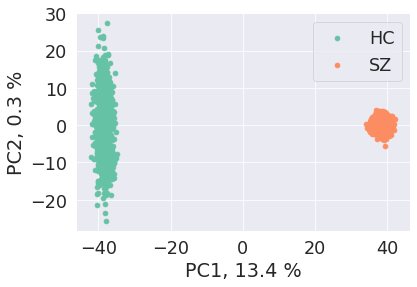

In [74]:
dim_reduction = PCA(n_components=2)
fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75_reduction)
plt.scatter(
    fake_dataset_dim_reduction[:N_SAMPLES, 0],
    fake_dataset_dim_reduction[:N_SAMPLES, 1],
    label="HC",
)
plt.scatter(
    fake_dataset_dim_reduction[N_SAMPLES:, 0],
    fake_dataset_dim_reduction[N_SAMPLES:, 1],
    label="SZ",
)
plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"n={N_SAMPLES} for each class")
plt.legend()
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_75_gen.png"
)
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_brain_as_object_75_gen.pdf",
    bbox_inches="tight",
)

### region as object

In [75]:
fake_dataset_75.shape

(100000, 320)

In [76]:
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding

In [77]:
from sklearn.decomposition import KernelPCA, TruncatedSVD

In [78]:
use_PCA = True
if use_PCA:
    dim_reduction = PCA(n_components=2)
else:
    dim_reduction = Isomap(n_components=2)

fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75.iloc[:, 2:])

In [79]:
border = fake_dataset_dim_reduction.shape[0] // 2

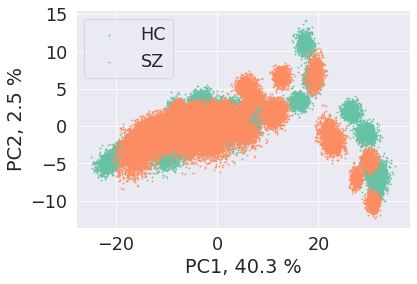

In [80]:
plt.scatter(
    fake_dataset_dim_reduction[:border, 0],
    fake_dataset_dim_reduction[:border, 1],
    label="HC",
    s=1,
)
plt.scatter(
    fake_dataset_dim_reduction[border:, 0],
    fake_dataset_dim_reduction[border:, 1],
    label="SZ",
    s=1,
)
if use_PCA:
    plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
    plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"Each point is a region\nn={N_SAMPLES} for each class\ndataset is normalized\nno variance added")
plt.legend()
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_75_gen_{'PCA' if use_PCA else 'tsne'}.png"
)
plt.savefig(
    f"../data/pics/{'genes' if use_genes else 'lipids'}_region_as_object_75_gen_{'PCA' if use_PCA else 'tsne'}.pdf",
    bbox_inches="tight",
)

## Plot lipids

NameError: name 'to_plot' is not defined

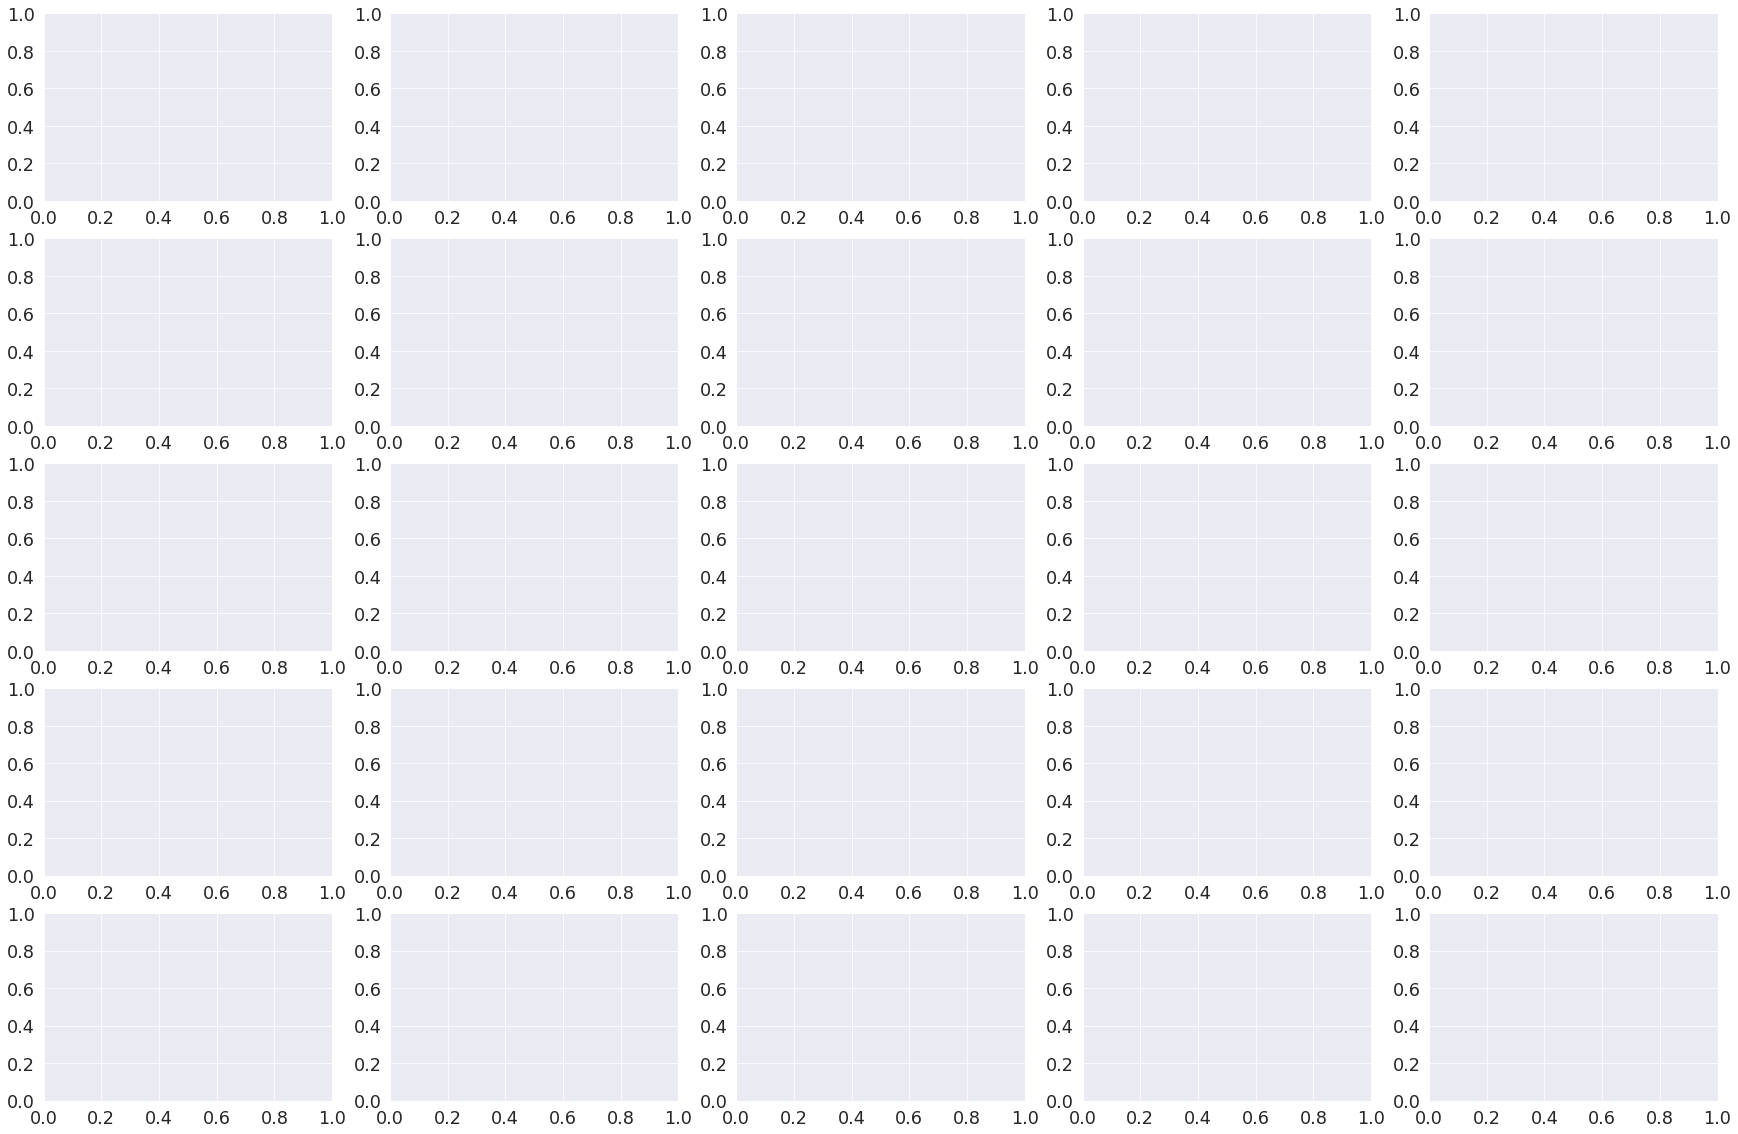

In [82]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(5 * 6, 5 * 4))
axs = axs.flatten()
for i in range(25):
    sns.histplot(to_plot.iloc[:, i + 9], kde=True, stat="density", ax=axs[i])
    sns.rugplot(to_plot.iloc[:, i + 9], ax=axs[i], height=0.1, linewidth=2)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
plt.savefig("../data/pics/lipids_distr.pdf", bbox_inches="tight")

# Training

## brain as object

In [48]:
half_len = len(fake_dataset_75) // 2
num_people = fake_dataset_75.human.nunique() // 2
hc_fake = fake_dataset_75.iloc[:half_len, 2:].values.reshape(num_people, -1)
sz_fake = fake_dataset_75.iloc[half_len:, 2:].values.reshape(num_people, -1)
train_dataset = np.vstack([hc_fake, sz_fake])
y = np.ones(2 * N_SAMPLES)
y[:N_SAMPLES] = 0

In [49]:
train_dataset.shape

(2000, 15900)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset, y, test_size=0.2, shuffle=True, random_state=435132
)

### Random Forest

In [51]:
rf = RandomForestClassifier(criterion="gini", random_state=3643216)

In [52]:
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

1.0

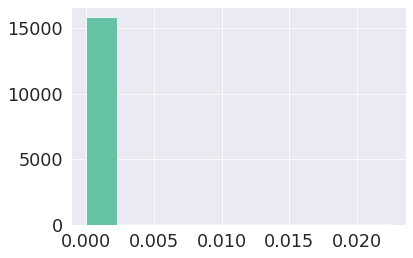

In [53]:
plt.hist(rf.feature_importances_)
plt.show()

In [54]:
feature_names = []
for region_nm in regions_only_four:
    feature_names += ((region_nm + "_") + pd.Series(common_molecules)).values.tolist()
feature_names = np.array(feature_names)

print(feature_names[rf.feature_importances_.argsort()[:-5:-1]])

['65 Hippocampus, CA1_PC_P 38 2' '8  Cingulate Posterior (BA23a)_PC 44 1'
 '61 Pulvinar Thalamus_FA 22 5' '23 Insular Anterior Cortex_HexCer t41 2']


In [55]:
importances_df = pd.DataFrame(
    np.vstack([feature_names, rf.feature_importances_]).T,
    columns=["feature name", "importance"],
)
importances_df = importances_df.sort_values(
    by="importance", ascending=False
).reset_index(drop=True)
importances_df.to_csv(
    f"../data/importances/{'genes' if use_genes else 'lipids'}_brain_rf_2.csv"
)

### Logreg + permutation

In [56]:
X_train = np.array(X_train)

In [57]:
scaler = StandardScaler()

In [58]:
X_train_scaled = scaler.fit_transform(X_train)

In [59]:
X_train.shape

(1600, 15900)

In [60]:
def make_importances(clf, X_train, y_train, feature_names, mode_name, clf_name):
    result = permutation_importance(
        clf, X_train, y_train, n_repeats=5, random_state=234325, n_jobs=-1
    )
    importances_df = pd.DataFrame(
        np.vstack([feature_names, result.importances_mean]).T,
        columns=["feature name", "importance"],
    )
    importances_df = importances_df.sort_values(
        by="importance", ascending=False
    ).reset_index(drop=True)
    importances_df.to_csv(
        f"../data/importances/{'genes' if use_genes else 'lipids'}_{mode_name}_perm_{clf_name}_2.csv"
    )

In [58]:
clf1 = LogisticRegression(solver="lbfgs", random_state=9843595, n_jobs=-1).fit(
    X_train_scaled, y_train
)
clf2 = LinearSVC(random_state=28734).fit(X_train_scaled, y_train)

In [ ]:
make_importances(clf1, X_train_scaled, y_train, feature_names, "brain", "logreg")
make_importances(clf2, X_train_scaled, y_train, feature_names, "brain", "svm")

## Region as object

In [60]:
fake_dataset_75.head()

,human,region,0,1,2,3,4,5,6,7,...,14167,14168,14169,14170,14171,14172,14173,14174,14175,14176
100,HC1,1 Cerebellar Grey Matter,-0.037698,-0.010649,0.176352,0.285609,-0.094256,-0.178571,-0.287203,-0.198786,...,1.322768,0.221017,-1.057745,-0.251455,-0.196477,-0.280805,-0.621037,0.195510,-0.375003,-0.048085
600,HC1,15 1ary Motor (BA4),-0.426097,-0.044475,-0.055471,0.050353,0.053122,-0.201770,-0.011539,-0.025544,...,-0.136521,-0.008161,0.080811,0.804801,0.359058,0.494292,-0.131432,0.192751,0.398988,0.124403
1000,HC1,16 1ary Auditory (BA41/42),-0.895576,0.026246,-0.122641,-0.064093,0.151654,-0.129899,-0.029164,0.012658,...,-0.195332,0.045030,-0.065205,-0.617080,-0.037194,1.084546,0.122761,-0.228213,0.057733,0.563484
1900,HC1,17 1ary Visual Anterior (BA17a),-0.139748,-0.058677,0.037892,-0.055781,-0.267894,0.081073,-0.238367,-0.188169,...,0.890670,0.062651,0.462929,-0.264278,0.108055,0.702541,1.005390,0.163447,0.124246,-0.135866
2000,HC1,18 1ary Somatosensory (BA3/1/2),0.391075,-0.063929,-0.055294,0.350292,-0.052095,-0.521547,-0.106466,0.096598,...,1.116170,-0.034027,-0.320868,-1.194609,-0.101099,-1.076620,-0.947130,-0.289876,0.448579,0.074630


In [61]:
train_dataset = fake_dataset_75.iloc[:, 2:]
y = np.ones(fake_dataset_75.shape[0])
y[: fake_dataset_75.shape[0] // 2] = 0
X_train, X_test, y_train, y_test, regions_train, regions_test = train_test_split(
    train_dataset,
    y,
    fake_dataset_75.region,
    test_size=0.2,
    shuffle=True,
    random_state=435132,
)

### Random Forest

In [62]:
rf = RandomForestClassifier(random_state=3643216).fit(X_train, y_train)

In [63]:
y_pred = rf.predict(X_test)

In [64]:
correst_classification = y_pred == y_test

In [65]:
clf_res = pd.concat(
    [regions_test.reset_index(drop=True), pd.Series(correst_classification)], axis=1
)
clf_res = clf_res.groupby("region")[0].apply(np.mean)
clf_res.index = clf_res.index.str.split().str[1:].str.join(" ")
clf_res = pd.DataFrame(clf_res).reset_index()
clf_res.columns = ["Region", "accuracy"]
clf_res = clf_res.sort_values(by="accuracy").reset_index(drop=True)

In [1]:
# print(clf_res.iloc[:5, :].to_latex(index=False))
# print(clf_res.iloc[-5:, :].to_latex(index=False))

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [ ]:
X_train, y_train = shuffle(train_dataset, y, random_state=239875)

In [ ]:
cv = cross_val_score(
    RandomForestClassifier(random_state=3643216), X_train, y_train, cv=5, n_jobs=-1
)

In [ ]:
cv.mean()

In [ ]:
plt.hist(rf.feature_importances_)
plt.show()

In [ ]:
X_train.shape

In [ ]:
# print(pd.DataFrame(common_molecules[rf.feature_importances_.argsort()][:-6:-1]).to_latex())
# print(", ".join(common_molecules[rf.feature_importances_.argsort()][:-6:-1].tolist()))

In [69]:
importances_df = pd.DataFrame(
    np.vstack([np.array(common_molecules), rf.feature_importances_]).T,
    columns=["feature name", "importance"],
)
importances_df = importances_df.sort_values(
    by="importance", ascending=False
).reset_index(drop=True)
importances_df.to_csv(
    f"../data/importances/{'genes' if use_genes else 'lipids'}_regions_rf_2.csv"
)

### Logreg + permutations (not suitable for genes, too slow)

In [70]:
X_train = np.array(X_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [58]:
clf1 = LogisticRegression(solver="lbfgs", random_state=9843595, n_jobs=-1).fit(
    X_train_scaled, y_train
)
clf2 = LinearSVC(random_state=28734).fit(X_train_scaled, y_train)

In [ ]:
make_importances(
    clf1, X_train_scaled, y_train, np.array(common_molecules), "regions", "logreg"
)
make_importances(
    clf2, X_train_scaled, y_train, np.array(common_molecules), "regions", "svm"
)